# Import all the packages needed for MORO

Import packages needed from ema_workbench

In [1]:
from ema_workbench import (Model, RealParameter, Policy, Constant, Scenario, Constraint, 
                           ScalarOutcome, MultiprocessingEvaluator, ema_logging, perform_experiments)
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.optimization import (EpsilonProgress, HyperVolume, ArchiveLogger)
from model.problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework import sample_uncertainties
from ema_workbench.em_framework.evaluators import BaseEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\georg\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

Import other needed packages

In [2]:
SEED = 42 
import numpy.random
import random
numpy.random.seed(SEED)
random.seed(SEED)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools
%matplotlib inline  

Define problem formulation and planning steps

In [3]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
ID_PF = 2    # assign problem_formulation_id
NR_STEPS = 2 # assign number of planning steps
dike_model, planning_steps = get_model_for_problem_formulation(ID_PF, NR_STEPS)

# Define the robustness metrics

The robustness metric chosen for dike costs, RfR costs and evaciation costs is the mean absolute performance across the set of scenarios. For the expected annual damage and expected number of deaths the robustness metric is the percentage of scenarios where the outcome is below a certain threshold. 

In [8]:
def mean_rob(data):
    return np.sum(data)/(data.shape[0]*1e9)

def threshold(direction, threshold, data):
    if direction == "SMALLER":
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

death_funcs = functools.partial(threshold, "SMALLER", 0.00001)
damage_funcs = functools.partial(threshold, "SMALLER", 10000)

robustness_functions = [ScalarOutcome('Robustness metric Damage', kind=ScalarOutcome.MAXIMIZE,
                             variable_name='Expected Annual Damage', function = damage_funcs),
                        ScalarOutcome('Robustness metric Dike Costs', kind=ScalarOutcome.MINIMIZE,
                             variable_name='Dike Investment Costs', function = mean_rob),
                        ScalarOutcome('Robustness metric RfR Costs', kind=ScalarOutcome.MINIMIZE,
                             variable_name='RfR Investment Costs', function = mean_rob),
                        ScalarOutcome('Robustness metric Evacuation Costs', kind=ScalarOutcome.MINIMIZE,
                             variable_name='Evacuation Costs', function = mean_rob),
                        ScalarOutcome('Robustness metric Deaths', kind=ScalarOutcome.MAXIMIZE,
                             variable_name='Expected Number of Deaths', function = death_funcs)]

# Check the number of needed scenarios

In this section the number of scenarios needed for the robustness metrics to stabilize. 

The number of scenarios and policies for which experiments will be performed in order to check the convergence of robustness metrics.  

In [5]:
scen = 300
pol = 12

In [32]:
%%time 
from ema_workbench import ema_logging, MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=scen,               
                                            policies=pol)

save_results(results, f"Outputs/perform_experiments/scen{scen}pol{pol}.tar.gz")

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 300 scenarios * 12 policies * 1 model(s) = 3600 experiments
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 1080 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2160 cases completed
[MainProcess/INFO] 2520 cases completed
[MainProcess/INFO] 2880 cases completed
[MainProcess/INFO] 3240 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\Outputs\perform_experiments\scen300pol12.tar.gz


Wall time: 18min 25s


Load the experiments 

In [6]:
results = load_results(f"Outputs/perform_experiments/scen{scen}pol{pol}.tar.gz")
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\Outputs\perform_experiments\scen300pol12.tar.gz


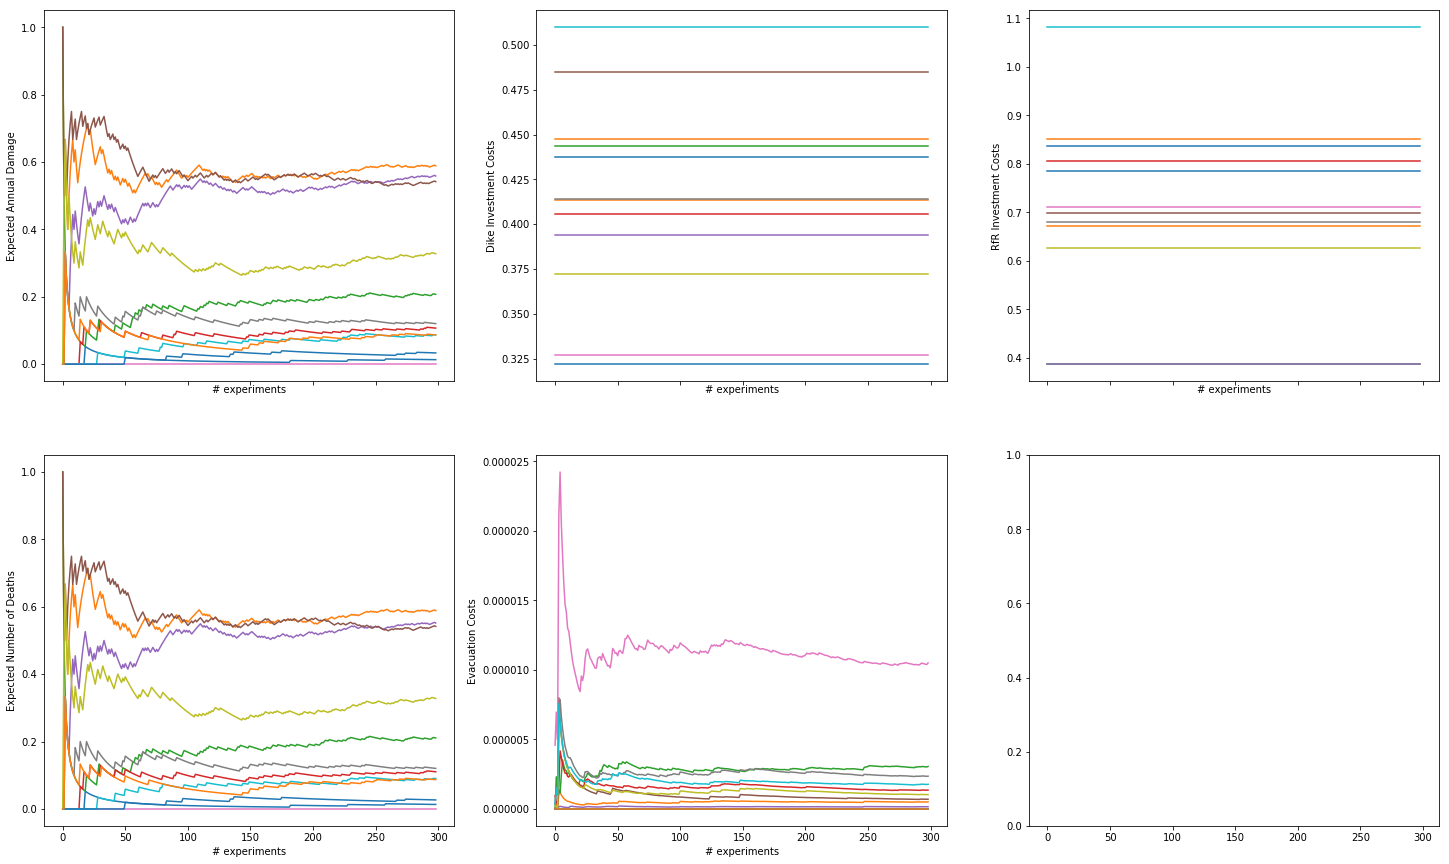

In [10]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(25,15),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[0,2],axes[1,1],axes[1,0],axes[1,1],axes[1,2]]  

robustness_funcs = {"Expected Number of Deaths": functools.partial(threshold, "SMALLER", 0.00001),
                    "Expected Annual Damage": functools.partial(threshold, "SMALLER", 100000), 
                    "RfR Investment Costs": mean_rob,
                    "Evacuation Costs": mean_rob,
                    "Dike Investment Costs": mean_rob}

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

# Perform the Multi Objective Robust Optimization

Set the parameters

In [20]:
n_scenarios = 100
nfe = 17500
scenarios = sample_uncertainties(dike_model, n_scenarios)
epsilons = [0.01, 0.01, 0.01, 0.01, 0.01]

We are running the MORO with a constraint for deaths, the MORO optimization due to high running time was executed in cloud.

In [11]:
%%time
BaseEvaluator.reporting_frequency = 15

# is the order of the hypervolume according to the order of the outcomes? 
convergence_metrics = [HyperVolume(minimum=[0,0,0,0,0], maximum=[1.1, 3 , 3, 3, 1.1]),
                       EpsilonProgress()]
 
constraint = [Constraint("Death constraint", outcome_names="Robustness metric Deaths", function=lambda x:max(0, 0.75-x))]
#             Constraint("Dike costs constraint", outcome_names="Robustness metric Dike Costs", function=lambda x:max(0, x-0.1))]

with MultiprocessingEvaluator(dike_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustness_functions, scenarios,
                            nfe=nfe, convergence=convergence_metrics, epsilons=epsilons, constraints=constraint, logging_freq = 1, convergence_freq = 10)

Load the results

In [16]:
archive, convergence = load_results("robust_optimization_17500nfe.tar")

[MainProcess/INFO] results loaded succesfully from C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\robust_optimization_17500nfe.tar


## Convergence of ε and hypervolume

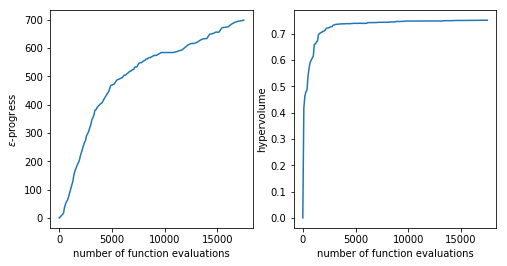

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence['nfe'], convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence['nfe'], convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()